In [1]:
import sys
sys.version

'3.4.5 |Anaconda custom (64-bit)| (default, Jul  5 2016, 14:53:07) [MSC v.1600 64 bit (AMD64)]'

In [2]:
import h5py
import csv
import numpy as np
import os
import gdal
import matplotlib.pyplot as plt
import sys
from math import floor
import time
import warnings
warnings.filterwarnings('ignore')

def h5refl2array(h5_filename):
    hdf5_file = h5py.File(h5_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN\n",
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)\n",
    mapInfo_split = mapInfo_string.split(",")
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]
    #Extract the upper left-hand corner coordinates from mapInfo\n",
    xMin = float(mapInfo_split[3]) #convert from string to floating point number\n",
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions\n",
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth'])) #xMax = left edge + (# of columns * resolution)\n",
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) #yMin = top edge - (# of rows * resolution)\n",
    metadata['extent'] = (xMin,xMax,yMin,yMax),
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    return reflArray, metadata, wavelengths

print('Starting BRDF Analysis')

Starting BRDF Analysis


In [3]:
# %load neon_aop_refl_hdf5_functions.py
# %load neon_aop_refl_hdf5_functions
"""
Created on Mon Feb  6 16:36:10 2017

@author: bhass

neon_aop_refl_hdf5_functions contains the following functions for use in the 
Remote Sensing Data Institute (June 19-25, 2017)

list_dataset (called with h5py.File.visititems):
    lists the name and location of each dataset stored in an hdf5 file 

ls_dataset (called with h5py.File.visititems):
    lists name, shape, and type of each dataset stored in an hdf5 file

h5refl2array(refl_filename): 
    reads in a NEON AOP reflectance hdf5 file and returns reflectance array, 
    select metadata, and wavelength dataset

extract_raw_band(reflArray,reflArray_metadata,band_ind):
    extracts a single band from a reflectance array without applying the scale 
    factor or data ignore value

clean_band(bandArray,reflArray_metadata):
    sets the data ignore value to NaN and applies the scale factor to a single 
    reflectance band array

extract_clean_band(reflArray,reflArray_metadata,band_ind):
    extracts a single band from a reflectance array, applies the scale factor 
    and sets the data ignore value to NaN

plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='', \
cmap_title='',colormap='spectral'):
    reads in and plots a single band of a reflectance array, or plots three 
    bands as an RGB image

array2raster(newRaster,reflBandArray,reflArray_metadata): 
    reads in a reflectance array and associated metadata and returns a geotif 
    raster named newRaster.tif

calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    calculates the indices relative to a full flight line extent of a subset 
    given a clip extent in UTM m (x,y)
    
subset_clean_refl(reflArray,reflArray_metadata,clipIndex):
    subsets a reflectance array to the specified clipIndex, and applies the no 
    data value and scale factor

stack_clean_bands(reflArray,reflArray_metadata,bands):
    generates an array of multiple bands, and applies the data ignore value and 
    scale factor to each band
    
subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    extracts a band from a reflectance array, subsets it to the specified 
    clipIndex, and applies the no data value and scale factor
    
stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    subsets, cleans, and stacks specified bands from a reflectance array

"""

#Import Required Packages:
import numpy as np
import matplotlib.pyplot as plt
import h5py, gdal, osr, copy

def list_dataset(name,node):
    
    """list_dataset lists the name and location of each dataset stored in an hdf5 file.
    --------
    See Also
    --------
    ls_dataset: 
        Lists name, shape, and type of each dataset stored in an hdf5 file.
    Example:
    --------
    f = h5py.File('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r') 
    f.visititems(list_dataset)"""
    
    if isinstance(node, h5py.Dataset):
        print(name)

def ls_dataset(name,node):
    
    """ls_dataset lists the name, shape, and datatype of each dataset stored in 
    an hdf5 file.
    --------
    See Also
    --------
    list_dataset: 
        Lists name and location of each dataset stored in an hdf5 file
    Example:
    --------
    f = h5py.File('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5','r') 
    f.visititems(ls_dataset)"""
    
    if isinstance(node, h5py.Dataset):
        print(node)

def h5refl2array(refl_filename):
    """h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, select metadata, and wavelength dataset.
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            EPSG: coordinate reference system code (integer)
            *bad_band_window1: [1340 1445] range of wavelengths to ignore
            *bad_band_window2: [1790 1955] range of wavelengths to ignore 
            ext_dict: dictionary of spatial extent 
            extent: array of spatial extent (xMin, xMax, yMin, yMax)
            mapInfo: string of map information 
            *noDataVal: -9999.0
            projection: string of projection information
            *res: dictionary containing 'pixelWidth' and 'pixelHeight' values (floats)
            *scaleFactor: 10000.0
            shape: tuple of reflectance shape (y, x, # of bands)
        * Asterixed values are the same for all NEON AOP hyperspectral reflectance 
        files processed 2016 & after.
    wavelengths:
        Wavelengths dataset. This is the same for all NEON AOP reflectance hdf5 files.
        wavelengths.value[n-1] gives the center wavelength for band n 
    --------
    This function applies to the NEON hdf5 format implemented in 2016, which 
    applies to data acquired in 2016 & 2017 as of June 2017. Data in earlier 
    NEON hdf5 format is expected to be re-processed after the 2017 flight season. 
    --------
    Example
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """
    
    #Read in reflectance hdf5 file (include full or relative path if data is located in a different directory)
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info'].value

    #Extract no data value & set no data value to NaN
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    
    #Extract bad band windows
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    mapInfo_string = str(mapInfo); 
    mapInfo_split = mapInfo_string.split(",")
    
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = float(mapInfo_split[5])
    metadata['res']['pixelHeight'] = float(mapInfo_split[6])
    
    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) #convert from string to floating point number
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions
    xMax = xMin + (refl_shape[1]*metadata['res']['pixelWidth']) #xMax = left edge + (# of columns * resolution)",
    yMin = yMax - (refl_shape[0]*metadata['res']['pixelHeight']) #yMin = top edge - (# of rows * resolution)",
    metadata['extent'] = (xMin,xMax,yMin,yMax) #useful format for plotting
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    
    return reflArray, metadata, wavelengths
    
def extract_raw_band(reflArray,reflArray_metadata,band_ind):
    
    """extract_raw_band extracts a single band from a reflectance array without applying the scale factor or data ignore value.
     --------
    Parameters
    --------
        reflArray: array of reflectance values, created from h5refl2array function
        reflArray_metadata: reflectance metadata values, created from h5refl2array function
        band_ind: index of wavelength band to be extracted
    --------
    Returns 
        bandArray: array of single band, without scale factor or data ignore value applied. 
    --------
    See Also
    --------
    clean_band: 
        Applies the data ignore value and scale factor to a single band array of reflectance data.
    extract_clean_band:
        Extracts a single band of data from a reflectance array and applies the data ignore value and scale factor.
    Example:
    --------
    SERC_b56_raw = extract_raw_band(sercRefl,sercRefl_md,56) """
    
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    return bandArray 

def clean_band(bandArray,reflArray_metadata):
        
    """clean_band sets the data ignore value to NaN and applies the scale factor to a single reflectance band array.
     --------
    Parameters
    --------
        bandArray: array of single band of reflectance values, created from extract_raw_band function
        reflArray_metadata: reflectance metadata values, created from h5refl2array function
    --------
    Returns 
        band_clean: array of single band, with scale factor applied and data ignore value set to NaN.
    --------
    See Also
    --------
    extract_raw_band: 
        Extracts a single band from a reflectance array without applying the scale factor or data ignore value.
    extract_clean_band:
        Extracts a single band of data from a reflectance array and applies the data ignore value and scale factor.
    Example:
    --------
    SERC_b56_clean = clean_band(SERC_b56_raw,sercRefl_md) """
    
    band_clean = copy.copy(bandArray) #make a copy of the array so you don't change the value of the original bandArray
    band_clean[band_clean==int(reflArray_metadata['noDataVal'])]=np.nan
    band_clean = band_clean/reflArray_metadata['scaleFactor']
    return band_clean

def extract_clean_band(reflArray,reflArray_metadata,band_ind):
    
    """extract_clean_band extracts a single band from a reflectance array, 
    applies the scale factor and sets the data ignore value to NaN.
    --------
    Parameters
    --------
        reflArray: array of reflectance values, created by h5refl2array function
        reflArray_metadata: reflectance metadata values, created by h5refl2array 
        band_ind: index of wavelength band to be extracted
    --------
    Returns 
        bandCleaned: array of single band, with scale factor applied and data ignore value set to NaN. 
    --------
    See Also
    --------
    extract_raw_band:
        Extracts a single band of data from a reflectance array and applies the 
        data ignore value and scale factor.
    clean_band:
        Applies the scale factor and sets the data ignore value to NaN for a 
        single reflectance band. 
    Example:
    --------
    SERC_b56_clean = extract_clean_band(sercRefl,sercRefl_md,56) """
    
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    bandCleaned = copy.copy(bandArray)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    return bandCleaned   

def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='spectral'):
    
    '''plot_band_array reads in and plots a single band of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
        plots flightline array of single band of reflectance data
    --------
    See Also
    --------
    plot_subset_band:
        plots a subset of a full flightline reflectance band array 
    Example:
    --------
    plot_band_array(SERC_b56_clean,sercRefl_md['extent'],(0,0.3),ax,title='SERC Band 56 Reflectance',cmap_title='Reflectance',colormap='spectral') ''' 
    
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

def array2raster(newRaster,reflBandArray,reflArray_metadata): 
    
    '''array2raster reads in a reflectance array and associated metadata and returns a geotif raster named newRaster.tif
    --------
    Parameters
    --------
        newRaster: string, name of new geotif raster created
        reflBandArray: reflectance array to be converted to raster
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
    --------
    Returns 
        newRaster.tif: geotif raster created from reflectance array and associated metadata
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    Example:
    --------
    array2raster('SERC_b56_clean.tif',SERC_b56_clean,sercRefl_md) ''' 
    
    cols = reflBandArray.shape[1]
    rows = reflBandArray.shape[0]
    pixelWidth = float(reflArray_metadata['res']['pixelWidth'])
    pixelHeight = -float(reflArray_metadata['res']['pixelHeight'])
    originX = reflArray_metadata['ext_dict']['xMin']
    originY = reflArray_metadata['ext_dict']['yMax']
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create('hopb_b56.tif', cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(reflBandArray)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(reflArray_metadata['epsg']) 
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    
    '''calc_clip_index calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    --------
    Parameters
    --------
        clipExtent: dictionary of extent of region 
        h5Extent: dictionary of extent of h5 file (from the h5refl2array function, this corresponds to metadata['ext_dict'])
        xscale: optional, pixel size in the x-dimension, default is 1m (applicable to NEON reflectance data)
        yscale: optional, pixel size in the y-dimension, default is 1m (applicable to NEON reflectance data)
    --------
    Returns 
        newRaster.tif: geotif raster created from reflectance array and associated metadata
    --------
    Notes
    --------
    The clipExtent must lie within the extent of the h5Extent for this function to work. 
    If clipExtent exceets h5Extent in any direction, the function will return an error message. 
    --------
    Example:
    --------
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    calc_clip_index(clipExtent, sercRefl, xscale=1, yscale=1) ''' 
    
    h5rows = h5Extent['yMax'] - h5Extent['yMin']
    h5cols = h5Extent['xMax'] - h5Extent['xMin']    
    
    ind_ext = {}
    ind_ext['xMin'] = round((clipExtent['xMin']-h5Extent['xMin'])/xscale)
    ind_ext['xMax'] = round((clipExtent['xMax']-h5Extent['xMin'])/xscale)
    ind_ext['yMax'] = round(h5rows - (clipExtent['yMin']-h5Extent['yMin'])/xscale)
    ind_ext['yMin'] = round(h5rows - (clipExtent['yMax']-h5Extent['yMin'])/yscale)
    
    return ind_ext

def subset_clean_refl(reflArray,reflArray_metadata,clipIndex):
    
    '''subset_clean_refl subsets a reflectance array to the specified clipIndex, and applies the no data value and scale factor
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which multiple bands (typically 3) are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        clipIndex: ditionary; indices relative to a full flight line extent of a subset given a clip extent (generated by calc_clip_index function)
    --------
    Returns 
        reflSubCleaned: array of subsetted reflectance with no data value set to NaN and scale factor applied
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    calc_clip_index:
        calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict']) 
    
    serc_subset = subset_clean_band(sercRefl,sercRefl_md,serc_subInd) '''
    
    reflSubCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],:].astype(np.float)
    reflSubCleaned[reflSubCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    reflSubCleaned = reflSubCleaned/reflArray_metadata['scaleFactor']
    return reflSubCleaned

def stack_clean_bands(reflArray,reflArray_metadata,bands):
        
    '''stack_clean_bands generates an array of three bands, and applies the data ignore value and scale factor to each band
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which three bands are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        bands: indices of bands to be stacked; bands must be between 0-426 (eg. bands=(60,30,20))
    --------
    Returns 
        stackedArray: array of stacked bands
    --------
    Notes
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    RGBbands = (58,34,19)
    sercRGBarray = stack_clean_bands(sercRefl,sercRefl_md,RGBbands) ''' 
    
    band_clean_dict = {}
    band_clean_names = []

    stackedArray = np.zeros((reflArray.shape[0],reflArray.shape[1],len(bands)),'uint8') #pre-allocate stackedArray matrix
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = extract_clean_band(reflArray,reflArray_metadata,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

def subset_clean_band(reflArray,reflArray_metadata,clipIndex,bandIndex):
    
    '''subset_clean_band extracts a band from a reflectance array, subsets it to the specified clipIndex, and applies the no data value and scale factor
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which multiple bands (typically 3) are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        clipIndex: ditionary; indices relative to a full flight line extent of a subset given a clip extent (generated by calc_clip_index function)
        bandIndex: band number to be extracted (integer between 1-426)
    --------
    Returns 
        bandCleaned: array of subsetted band with no data value set to NaN and scale factor applied
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    calc_clip_index:
        calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict']) 
    
    serc_b58_subset = subset_clean_band(sercRefl,sercRefl_md,serc_subInd,58) '''
    
    bandCleaned = reflArray[clipIndex['yMin']:clipIndex['yMax'],clipIndex['xMin']:clipIndex['xMax'],bandIndex-1].astype(np.float)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    
    return bandCleaned 

def stack_subset_bands(reflArray,reflArray_metadata,bands,clipIndex):
    
    '''stack_subset_bands subsets, cleans, and stacks specified bands from a reflectance array
    --------
    Parameters
    --------
        reflArray: reflectance array of dimensions (y,x,426) from which multiple bands (typically 3) are extracted
        reflArray_metadata: reflectance metadata associated with reflectance array (generated by h5refl2array function)
        bands: indices of bands to be stacked; bands must be between 0-426 (eg. bands=(60,30,20))
        clipIndex: indices relative to a full flight line extent of a subset given a clip extent, (generated by calc_clip_index function)
    --------
    Returns 
        stackedArray: array of subsetted, stacked bands with no data value set to NaN and scale factor applied
    --------
    See Also
    --------
    h5refl2array: 
        reads in a NEON hdf5 reflectance file and returns the reflectance array, select metadata, and the wavelength dataset
    calculcate_clip_index:
        calculates the indices relative to a full flight line extent of a subset given a clip extent in UTM m (x,y)
    subset_clean_band:
        extracts, subsets, and cleans a single band from a reflectance array
    --------
    Example:
    --------
    sercRefl, sercRefl_md, wavelengths = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5')
    RGBbands = (58,34,19)
    clipExtent = {'xMax': 368100.0, 'xMin': 367400.0, 'yMax': 4306350.0, 'yMin': 4305750.0}
    serc_subInd = calc_clip_index(clipExtent,sercRefl_md['ext_dict']) 
    
    sercRGBarray = stack_subset_bands(sercRefl,sercRefl_md,RGBbands,serc_subInd) ''' 

    subArray_rows = clipIndex['yMax'] - clipIndex['yMin']
    subArray_cols = clipIndex['xMax'] - clipIndex['xMin']
    
    stackedArray = np.zeros((subArray_rows,subArray_cols,len(bands)),'uint8') #pre-allocate stackedArray matrix
    band_clean_dict = {}
    band_clean_names = []
    
    for i in range(len(bands)):
        band_clean_names.append("b"+str(bands[i])+"_refl_clean")
        band_clean_dict[band_clean_names[i]] = subset_clean_band(reflArray,reflArray_metadata,clipIndex,bands[i])
        stackedArray[...,i] = band_clean_dict[band_clean_names[i]]*256
                        
    return stackedArray

In [4]:
#these coordinates can be changed to regenerate the family of curves
BRDF_rectangle = np.array([[740315,3982265],[740928,3981839]],np.float)

In [5]:
x_coord = 740600
y_coord = 3982000

In [6]:
if BRDF_rectangle[0,0] <= x_coord <= BRDF_rectangle[1,0] and BRDF_rectangle[1,1] <= y_coord <= BRDF_rectangle[0,1]:
    print('Point in bounding area')
    y_index = floor(x_coord - BRDF_rectangle[0,0])
    x_index = floor(BRDF_rectangle[0,1] - y_coord)
else:
    print('Point not in bounding area, exiting')
    raise Exception('exit')

Point in bounding area


In [7]:
h5_directory = '../Day3_uncertainty/F07A/'

In [8]:
files = os.listdir(h5_directory)
h5_files = [i for i in files if i.endswith('.h5')]

In [9]:
#print(h5_files)

fig=plt.figure()
ax = plt.subplot(111)

In [10]:
#creates lists to store the NIR and red vales, as well as the filenames
nir_values = []
red_values = []
filename_names = []

#the loop here is the same as Day 3 lesson 2, but it has a few additions noted below
for file in h5_files:

    print('Working on ' + file)
    
    [reflArray,metadata,wavelengths] = h5refl2array(h5_directory+file)
    bad_band_window1 = (metadata['bad_band_window1'])
    bad_band_window2 = (metadata['bad_band_window2'])

    index_bad_window1 = [i for i, x in enumerate(wavelengths) if x > bad_band_window1[0] and x < bad_band_window1[1]]
    index_bad_window2 = [i for i, x in enumerate(wavelengths) if x > bad_band_window2[0] and x < bad_band_window2[1]]
    
    index_bad_windows = index_bad_window1+index_bad_window2
    reflectance_curve = np.asarray(reflArray[y_index,x_index,:], dtype=np.float32)
    if reflectance_curve[0] == metadata['noDataVal']:
        continue
    reflectance_curve[index_bad_windows] = np.nan
    
    #once the bad windows and NaN values are accounted for, the reflectance values at band 90 (NIR) and 58 (red) are extracted
    #to the lists above
    nir_values.append(reflectance_curve[90])
    red_values.append(reflectance_curve[58])
    filename_split = (file).split("_")
    
    #the filenames are extracted to the list above
    filename_names.append(filename_split[5]) 


Working on NEON_D07_F07A_DP1_20160611_160444_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_160846_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_161228_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_161532_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162007_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162514_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_162951_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_163424_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_163945_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_164259_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_164809_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_165240_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_165711_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_170118_reflectance_modify.h5
Working on NEON_D07_F07A_DP1_20160611_170538_reflectance_modif

In [11]:
#converts the lists to arrays
filenames_array = np.array(filename_names)
nir_calc_array = np.array(nir_values)
red_calc_array = np.array(red_values)

#calculates ndvi and stores them in arrays
ndvi_array = np.divide((nir_calc_array-red_calc_array),(nir_calc_array+red_calc_array))
ndvi_array

array([ 0.91920036,  0.85468894,  0.89944547,  0.86542445,  0.89053255,
        0.88919163,  0.87447035,  0.89148128,  0.87687093,  0.88682342,
        0.85174823,  0.86635053,  0.86827826,  0.87637967,  0.86536169,
        0.89559639], dtype=float32)

In [12]:
#creates a new but identical array to facilitate labeling below
filenames_lbl = filenames_array
ndviax = plt.subplot(111)
ndviax.scatter(filenames_array,ndvi_array,marker="o",color='blue',label=filenames_array)

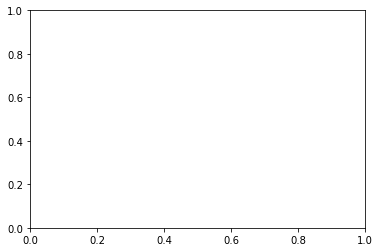

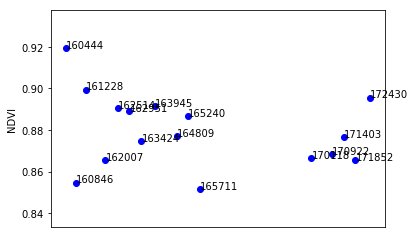

In [13]:
#declare scatterplot that plots the NDVI values from all 16 images
#a potential criticism is that Python is recognizing the image files as integers and not strings, so it is arranging them in 
#numerical order
#disregard the extra empty plot
ndviax.axes.get_xaxis().set_visible(False)
for i, lbl in enumerate(filenames_lbl):
    plt.annotate(lbl, (filenames_array[i],ndvi_array[i]))
plt.ylabel('NDVI')
plt.show()